# Analytical Heat Eqaution

Begin by exploring the 1D heat equation

$u_{t}=k u_{xx}$ for $x \in (0,1)$ for $t>0$

$u(x,0)=f(x)$  
$u(0,t)= T_0$  
$u(l,t)= T_l$

$\alpha = \frac{k}{\rho C_{p}}$
Assumptions:
- No heat generation
- Uniform material properties



$T(x,t) = T_{s}+(T_{i}-T_{s})erf(\frac{x}{2 \sqrt{\alpha t}})$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pydmd import DMD
import pysindy as ps

from sklearn.linear_model import Lasso as skLasso
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

from PDE_FIND import *

Transient cooling by Newton's law of cooling

In [3]:
# Define equation for temp over time
def T(input_vars, t):
    As = 4 * np.pi * input_vars[2]**2    # Surface area
    V = (4/3) * np.pi * input_vars[2]**3 # Volume
    b = (input_vars[3] * As)/(input_vars[4] * V * input_vars[5])
    return(input_vars[1] + (input_vars[0] - input_vars[1]) * np.exp(-b*t))

In [ ]:
# input_vars = {"T_i": T_i,
#               "T_inf":T_inf,
#               "r":r,
#               "h":h,
#               "rho":rho,
#               "Cp":Cp}

# np.array(list(input_vars.values()))

# Define equation for temp over time
# def T(T_i, T_inf, r, h, rho, cp, t):
#     As = 4 * np.pi * r**2    # Surface area
#     V = (4/3) * np.pi * r**3 # Volume
#     b = (h * As)/(rho * V * Cp)
#     return(T_inf + (T_i - T_inf) * np.exp(-b*t))

# Using lumped mass approximation

T_inf = 100   # Surrounding temperature
T_i = 0       # Initial temperature
r =  1/2000   # Radius of sphere
h = 210       # Convection heat transfer coefficient
rho = 8500    # Material density
Cp = 320      # Specific heat

rng = np.random.default_rng(42)  # Seed for reproducibility

input_vars = np.array([T_i, T_inf, r, h, rho, Cp])

# Setup experiment times
dt = 0.2      # Timestep

t_tr = 10     # Experiment train time
t_te= 20      # Experiment test time

t_train = np.arange(0,t_tr, dt) # Time array
t_test = np.arange(0,t_te, dt)  # Time array

# # Alternative initial conditions
# n_init_temps = 10
# Ti_rand = rng.uniform(low=80, high=120, size=n_init_temps)

# T_i_input_vars = input_vars.copy()
# T_i_models = []
# for i, Ti in enumerate(Ti_rand):
#     T_i_input_vars[0] = Ti

x0_train = input_vars
x_train = T(x0_train, t_train)

x0_test = input_vars.copy()
x0_test[0] = rng.uniform(low=80, high=120)
x_test = T(x0_test, t_test)

# input_vars0_train = input_vars.copy()
# #Temps0_train = T_train(input_vars0_train, t_train)
# input_vars0_test = input_vars0_train.copy()
# input_vars0_test[0] = T_i0# Change initial conditions
# Temps0_test = T(input_vars0_test, t_test)
# print(input_vars0_test)


# input_vars1_test = input_vars0_train.copy()
# input_vars1_test[1] = 80 # Change initial conditions
# Temps1_test = T(input_vars1_test, t_test)

# input_vars2_test = input_vars0_train.copy()
# input_vars2_test[0] = -20 # Change initial conditions
# Temps2_test = T(input_vars2_test, t_test)
#plt.figure(1)
#plt.plot(t_test, Temps_test, color="k", linestyle="-")
#plt.plot(t_train, Temps_train, color="r", linestyle="-")

In [4]:
# Using lumped mass approximation

T_inf = 100   # Surrounding temperature
T_i = 0       # Initial temperature
r =  1/2000   # Radius of sphere
h = 210       # Convection heat transfer coefficient
rho = 8500    # Material density
Cp = 320      # Specific heat

rng = np.random.default_rng(42)  # Seed for reproducibility

input_vars = np.array([T_i, T_inf, r, h, rho, Cp])

# Setup experiment times
dt = 0.2      # Timestep

t_tr = 10     # Experiment train time
t_te= 20      # Experiment test time

t_train = np.arange(0,t_tr, dt) # Time array
t_test = np.arange(0,t_te, dt)  # Time array

x0_train = input_vars
x_train = T(x0_train, t_train)

x0_test = input_vars.copy()
x0_test[0] = rng.uniform(low=80, high=120)
x_test = T(x0_test, t_test)

In [27]:
poly_lib = ps.PolynomialLibrary() #degree=2
fourier_lib = ps.FourierLibrary() #n_frequencies=3

custom_func = [
    lambda x : np.exp(x),
    lambda x : x,
    lambda x : x**2
]
custom_func_names = [
    lambda x : f"exp({x})",
    lambda x : x,
    lambda x : f"{x}**2"
]

custom_lib = ps.CustomLibrary(library_functions=custom_func, function_names=custom_func_names)

In [30]:
%%capture --no-stdout
# Hide annoying warnings

model = ps.SINDy(feature_names="T", t_default=dt)
x_dot = model.differentiate(x_train, t=t_train)

param_grid = {
    "optimizer__threshold": [0.001, 0.01, 0.1],
    "optimizer__alpha": [0.01, 0.05, 0.1],
    "feature_library": [ps.PolynomialLibrary(),
                        ps.FourierLibrary(),
                        ps.CustomLibrary(library_functions=custom_func, function_names=custom_func_names)],
    "differentiation_method__order": [1, 2]
}

search = GridSearchCV(
    model,
    param_grid,
    cv=TimeSeriesSplit(n_splits=5)
)
search.fit(x_train)

print("Best parameters:", search.best_params_)
search.best_estimator_.print()

Best parameters: {'differentiation_method__order': 2, 'feature_library': PolynomialLibrary(), 'optimizer__alpha': 0.01, 'optimizer__threshold': 0.001}
T' = 46.375 1 + -0.464 T


In [9]:
print(f"Model score: {model.score(x0_test, t=dt)}")
#print(f"Model score: {model.score(Temps1_test, t=dt)}")
#print(f"Model score: {model.score(Temps2_test, t=dt)}")

AttributeError: 'SINDy' object has no attribute 'n_control_features_'

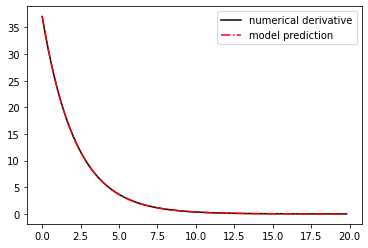

In [6]:
# Calculate derivatives
T_dot_test_predicited = model.predict(Temps0_test)
T_dot_test_computed = model.differentiate(Temps0_test, t=dt)

plt.plot(t_test, T_dot_test_computed, color="k", label="numerical derivative")
plt.plot(t_test, T_dot_test_predicited, color="r", linestyle= "-.", label="model prediction")
plt.legend()

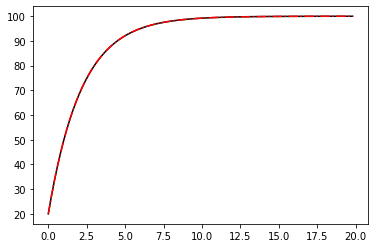

In [7]:
# Simulate forward in time
T0_test_sim = model.simulate(T_i0, t_test)

plt.plot(t_test, Temps0_test, color="k", label="true simulation")
plt.plot(t_test, T0_test_sim, color="r", linestyle="-.", label="model prediction")

In [2]:


combined_lib = poly_lib + fourier_lib

threshold=0.05
model2 = ps.SINDy(optimizer=ps.STLSQ(threshold=threshold), feature_library=custom_lib)
model2.fit(Temps0_train, t=dt)
model2.print(lhs=["dT/dt"])

NameError: name 'ps' is not defined

In [9]:
print(f"Model score: {model2.score(Temps0_test, t=dt)}")
print(f"Model score: {model2.score(Temps1_test, t=dt)}")
print(f"Model score: {model2.score(Temps2_test, t=dt)}")

Model score: -0.27557920205720987
Model score: -0.2755792020572101
Model score: -0.27557920205720987


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
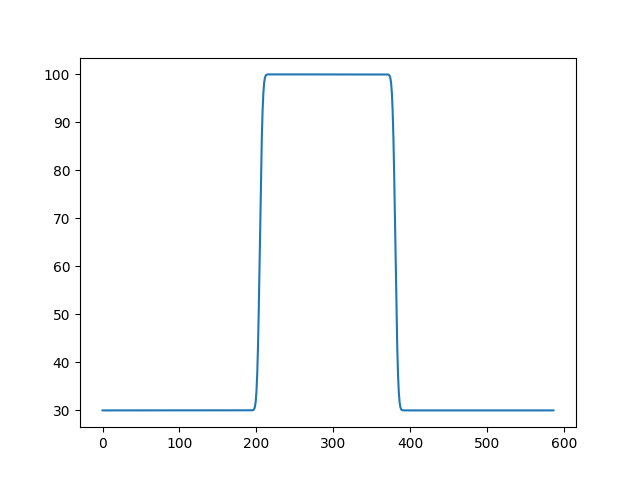

In [14]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

from IPython.display import HTML

fig, ax = plt.subplots()

L = 1

nx = 587
dx = L / (nx - 1)
nt = 20    #the number of timesteps we want to calculate
t_stop = 500
nu = 0.3   #the value of viscosity/thermal conductivity
sigma = .2 #sigma is a parameter, we'll learn more about it later
dt = sigma * dx**2 / nu #dt is defined using sigma ... more later!

t = np.arange(0, t_stop, dt)

u = 30*np.ones(nx)      # Setup initial conditions
u[int(0.35*L / dx):int(0.65*L / dx + 1)] = 100  # Set initial conditions

# def q(T, t):
#     dTdt = np.zeros_like(T)
#     dTdt[0] = T[1]
    
#     delta = T[2] - T[0]
    
un = np.ones(nx) #our placeholder array, un, to advance the solution in time

for n in range(nt):  #iterate through time
    un = u.copy() ##copy the existing values of u into un
    for i in range(1, nx - 1):
        u[i] = un[i] + nu * dt / dx**2 * (un[i+1] - 2 * un[i] + un[i-1])
        #plt.plot(np.linspace(0, 2, nx), u);
        
plt.plot(u)

In [11]:
plt.plot()

[]